# Clustering of the data

Le clustering consiste à regrouper un ensemble d'objet de telle sorte que les objets d'un même groupe (cluster) sont plus similaire entre eux qu'avec les autres groupes.

## Digits

In [3]:
from sklearn.datasets import load_digits, fetch_20newsgroups
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA, TruncatedSVD, LatentDirichletAllocation
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.svm import SVC
import lightgbm as lgb
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 

### Plot the digits

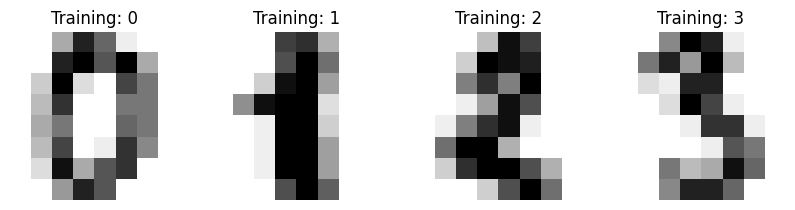

In [92]:
# Visualising some digits
digits = load_digits()
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title(f"Training: {label}")

In [93]:
# Get the digits between training and test
X, y = digits["data"], digits["target"]

In [94]:
y.shape

(1797,)

In [95]:
X.shape

(1797, 64)

Il y a 1797 images de 8x8 pixels.

In [96]:
# Normalise the data
X /= X.max()

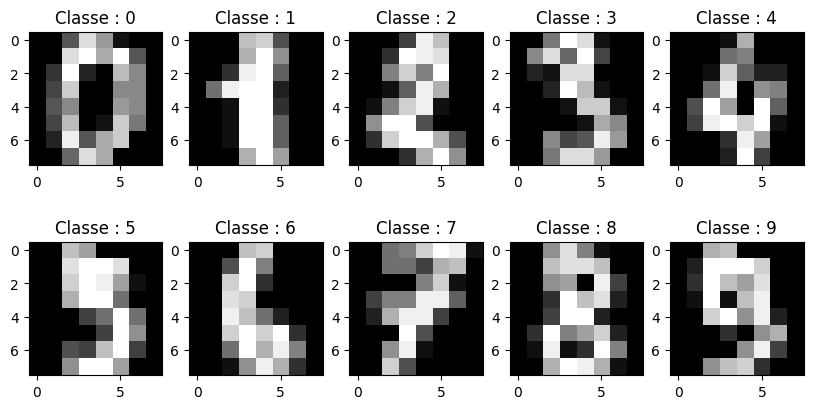

In [97]:
# Affichez quelques images
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(X[i].reshape(8, 8), cmap="gray")
    ax.set_title(f"Classe : {y[i]}")
plt.show()

In [98]:
# define the model
kmeans = KMeans(n_clusters=10, n_init="auto")

In [99]:
# fit the model
kmeans.fit(X)

KMeans(n_clusters=10, n_init='auto')

In [100]:
# get some predictions
X_pred = kmeans.predict(X)

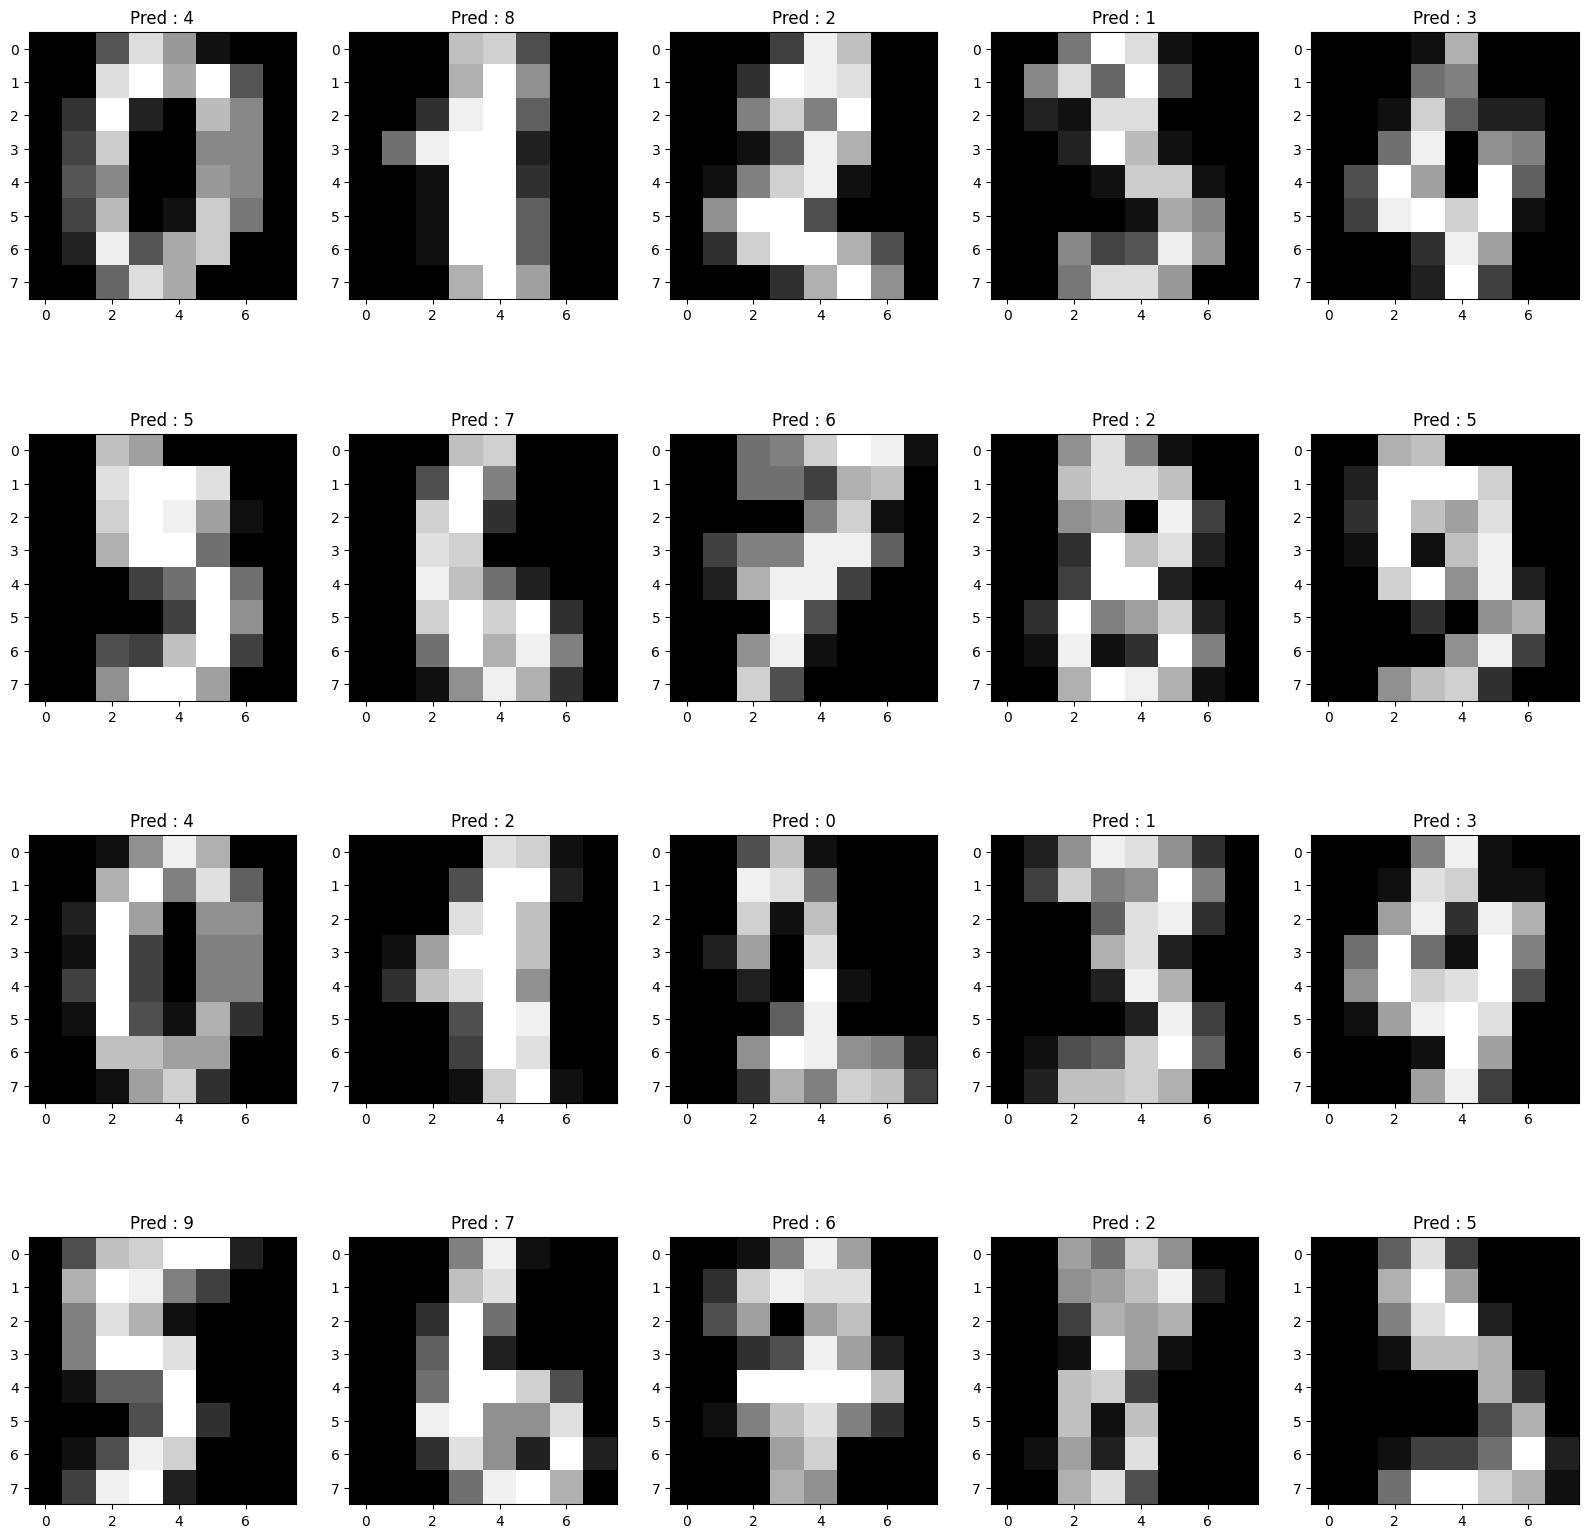

In [101]:
# Affichez quelques predictions
fig, axes = plt.subplots(4, 5, figsize=(20, 20))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(X[i].reshape(8, 8), cmap="gray")
    ax.set_title(f"Pred : {X_pred[i]}")
plt.show()

In [102]:
# Compute some unsupervised score for the given model
def bench_estimator(estimator, data, y=None):
    estimator.fit(data)
    scores = [
        "adjusted_rand_score",
        "adjusted_mutual_info_score",
        "silhouette_score",
        "homogeneity_score",
        "completeness_score",
        "v_measure_score",
    ]

    results = []
    for s in scores:
        if estimator == kmeans:
            predict = estimator.labels_
        else:
            predict = estimator.transform(data)
        if s not in ["silhouette_score"]:
            # with ground-truth
            # Yeah !
            score = getattr(metrics, s)(y, predict)
        elif y is not None:
            # with NO ground-truth
            score = getattr(metrics, s)(data, predict)
        else:
            continue
            
        results.append(score)
        
    return pd.DataFrame([results], columns=scores, index=["result"])

In [103]:
# display scores
bench_estimator(kmeans, X, y)

,adjusted_rand_score,adjusted_mutual_info_score,silhouette_score,homogeneity_score,completeness_score,v_measure_score
result,0.668038,0.740378,0.182277,0.738851,0.747128,0.742967


NMI et v mesure plus intéressant préférable avec ground Thruth, sans vérité terrain shilouette score. Indice de kalinsky pour voir la répartition des clusters. Kmeans centroid les plus loins possible et point les plus proches.

rand et adjusted rand nécessite l'ordre

Si l'inertie est élevé distance grande

In [105]:
# transform the data from 64D to 2D
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(X)

In [106]:
# predict the labels
cluster_labels = kmeans.fit_predict(reduced_data)

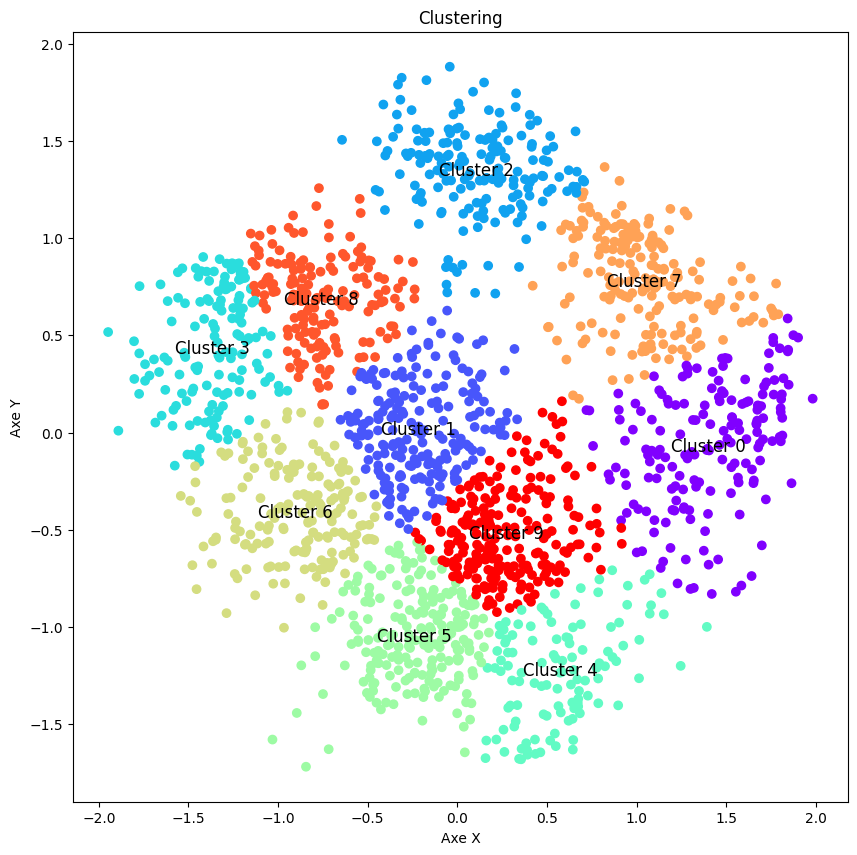

In [107]:
# visualise the clusters
cluster_names = {i: f"Cluster {i}" for i in range(cluster_labels.max() + 1)}
fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_labels, cmap='rainbow')
plt.xlabel('Axe X')
plt.ylabel('Axe Y')
plt.title('Clustering')
for cluster_id, cluster_name in cluster_names.items():
    cluster_points = reduced_data[cluster_labels == cluster_id]
    cluster_center = cluster_points.mean(axis=0)
    plt.text(cluster_center[0], cluster_center[1], cluster_name, fontsize=12, ha='center', va='center')


## Newsgroups

### Cluster with k-means

In [4]:
# Get the data
X, y = fetch_20newsgroups(
                        shuffle=True,
                        random_state=1,
                        remove=("headers", "footers", "quotes"),
                        return_X_y=True,
                        )

In [9]:
# diplay the data
for line in X[::100000]:
    print(line)

Well i'm not sure about the story nad it did seem biased. What
I disagree with is your statement that the U.S. Media is out to
ruin Israels reputation. That is rediculous. The U.S. media is
the most pro-israeli media in the world. Having lived in Europe
I realize that incidences such as the one described in the
letter have occured. The U.S. media as a whole seem to try to
ignore them. The U.S. is subsidizing Israels existance and the
Europeans are not (at least not to the same degree). So I think
that might be a reason they report more clearly on the
atrocities.
	What is a shame is that in Austria, daily reports of
the inhuman acts commited by Israeli soldiers and the blessing
received from the Government makes some of the Holocaust guilt
go away. After all, look how the Jews are treating other races
when they got power. It is unfortunate.



#### Vectorizing the text with CountVectorizer

In [11]:
# vectorize the data with CountVectorizer
vectorizer = CountVectorizer(max_df=0.5, min_df=2, stop_words='english') # max_df plus de 50%, min_df moins de 2
X_tf = vectorizer.fit_transform(X)
print(vectorizer.get_feature_names_out()) # vectorizer.get_feature_names_out()

['00' '000' '0000' ... 'zyra' 'zyxel' 'zz']


In [124]:
# split the data into train and test
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(X_tf, y, test_size=0.2, random_state=42)

In [114]:
# use the elbow method to find the optimal number of clusters
Sum_of_squared_distances = []
K = range(1,20)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X_train)
    Sum_of_squared_distances.append(km.inertia_)

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KeyboardInterrupt: 

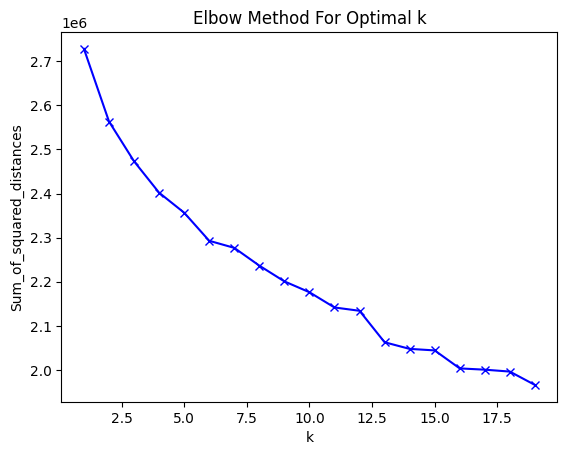

In [ ]:
# plot the elbow method
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

We can see that the optimal number of clusters is 20

In [115]:
# define and fit the model
kmeans = KMeans(n_clusters=len(np.unique(y_train_tf)), n_init="auto", random_state=42)
kmeans.fit(X_train_tf)

KMeans(n_clusters=20, n_init='auto', random_state=42)

In [117]:
# display the results
bench_k_means(kmeans, X_test_tf, y_test_tf)

,adjusted_rand_score,adjusted_mutual_info_score,silhouette_score,homogeneity_score,completeness_score,v_measure_score
result,0.000026,0.002196,0.753363,0.010537,0.345965,0.020451


#### Vectorizing with TF-IDF

In [181]:
# vectorize the data with TfidfVectorizer
dict_count_vectorizers = {"vectorizer": []}
vectorizer = TfidfVectorizer(max_df=0.5, min_df=2, stop_words='english') # max_df plus de 50%, min_df moins de 2
X_tfidf = vectorizer.fit_transform(X)
dict_count_vectorizers["vectorizer"].append(vectorizer.__class__.__name__)
print(f"Found {len(vectorizer.get_feature_names_out())} unique terms")

Found 39115 unique terms


In [182]:
# split the data into train and test
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [127]:
# fit the model with the tfidf vectorizer
kmeans.fit(X_train_tfidf)

KMeans(n_clusters=20, n_init='auto', random_state=42)

In [155]:
# make a function to display the top words in each cluster
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(4, 5, figsize=(30, 40), sharex=True)
    axes = axes.flatten()
    # For each cluster get the five higher words and their weight
    if model == kmeans:
        model_cluster = model.cluster_centers_
    else:
        model_cluster = model.components_
    for topic_idx, topic in enumerate(model_cluster):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

    # Plot in bar the five higher words according to their weight
        ax = axes[topic_idx]
        bars = ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Cluster {topic_idx +1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

        # Ajout des annotations
        for bar, weight in zip(bars, weights):
            ax.annotate(f'{weight:.2f}', 
                        xy=(weight, bar.get_y() + bar.get_height() / 2),
                        xytext=(3, 0),  # 3 points de décalage à gauche
                        textcoords="offset points",
                        fontsize=12,
                        color='black',
                        ha='left', va='center')

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [ ]:
# get the feature names
feature_names = vectorizer.get_feature_names_out()

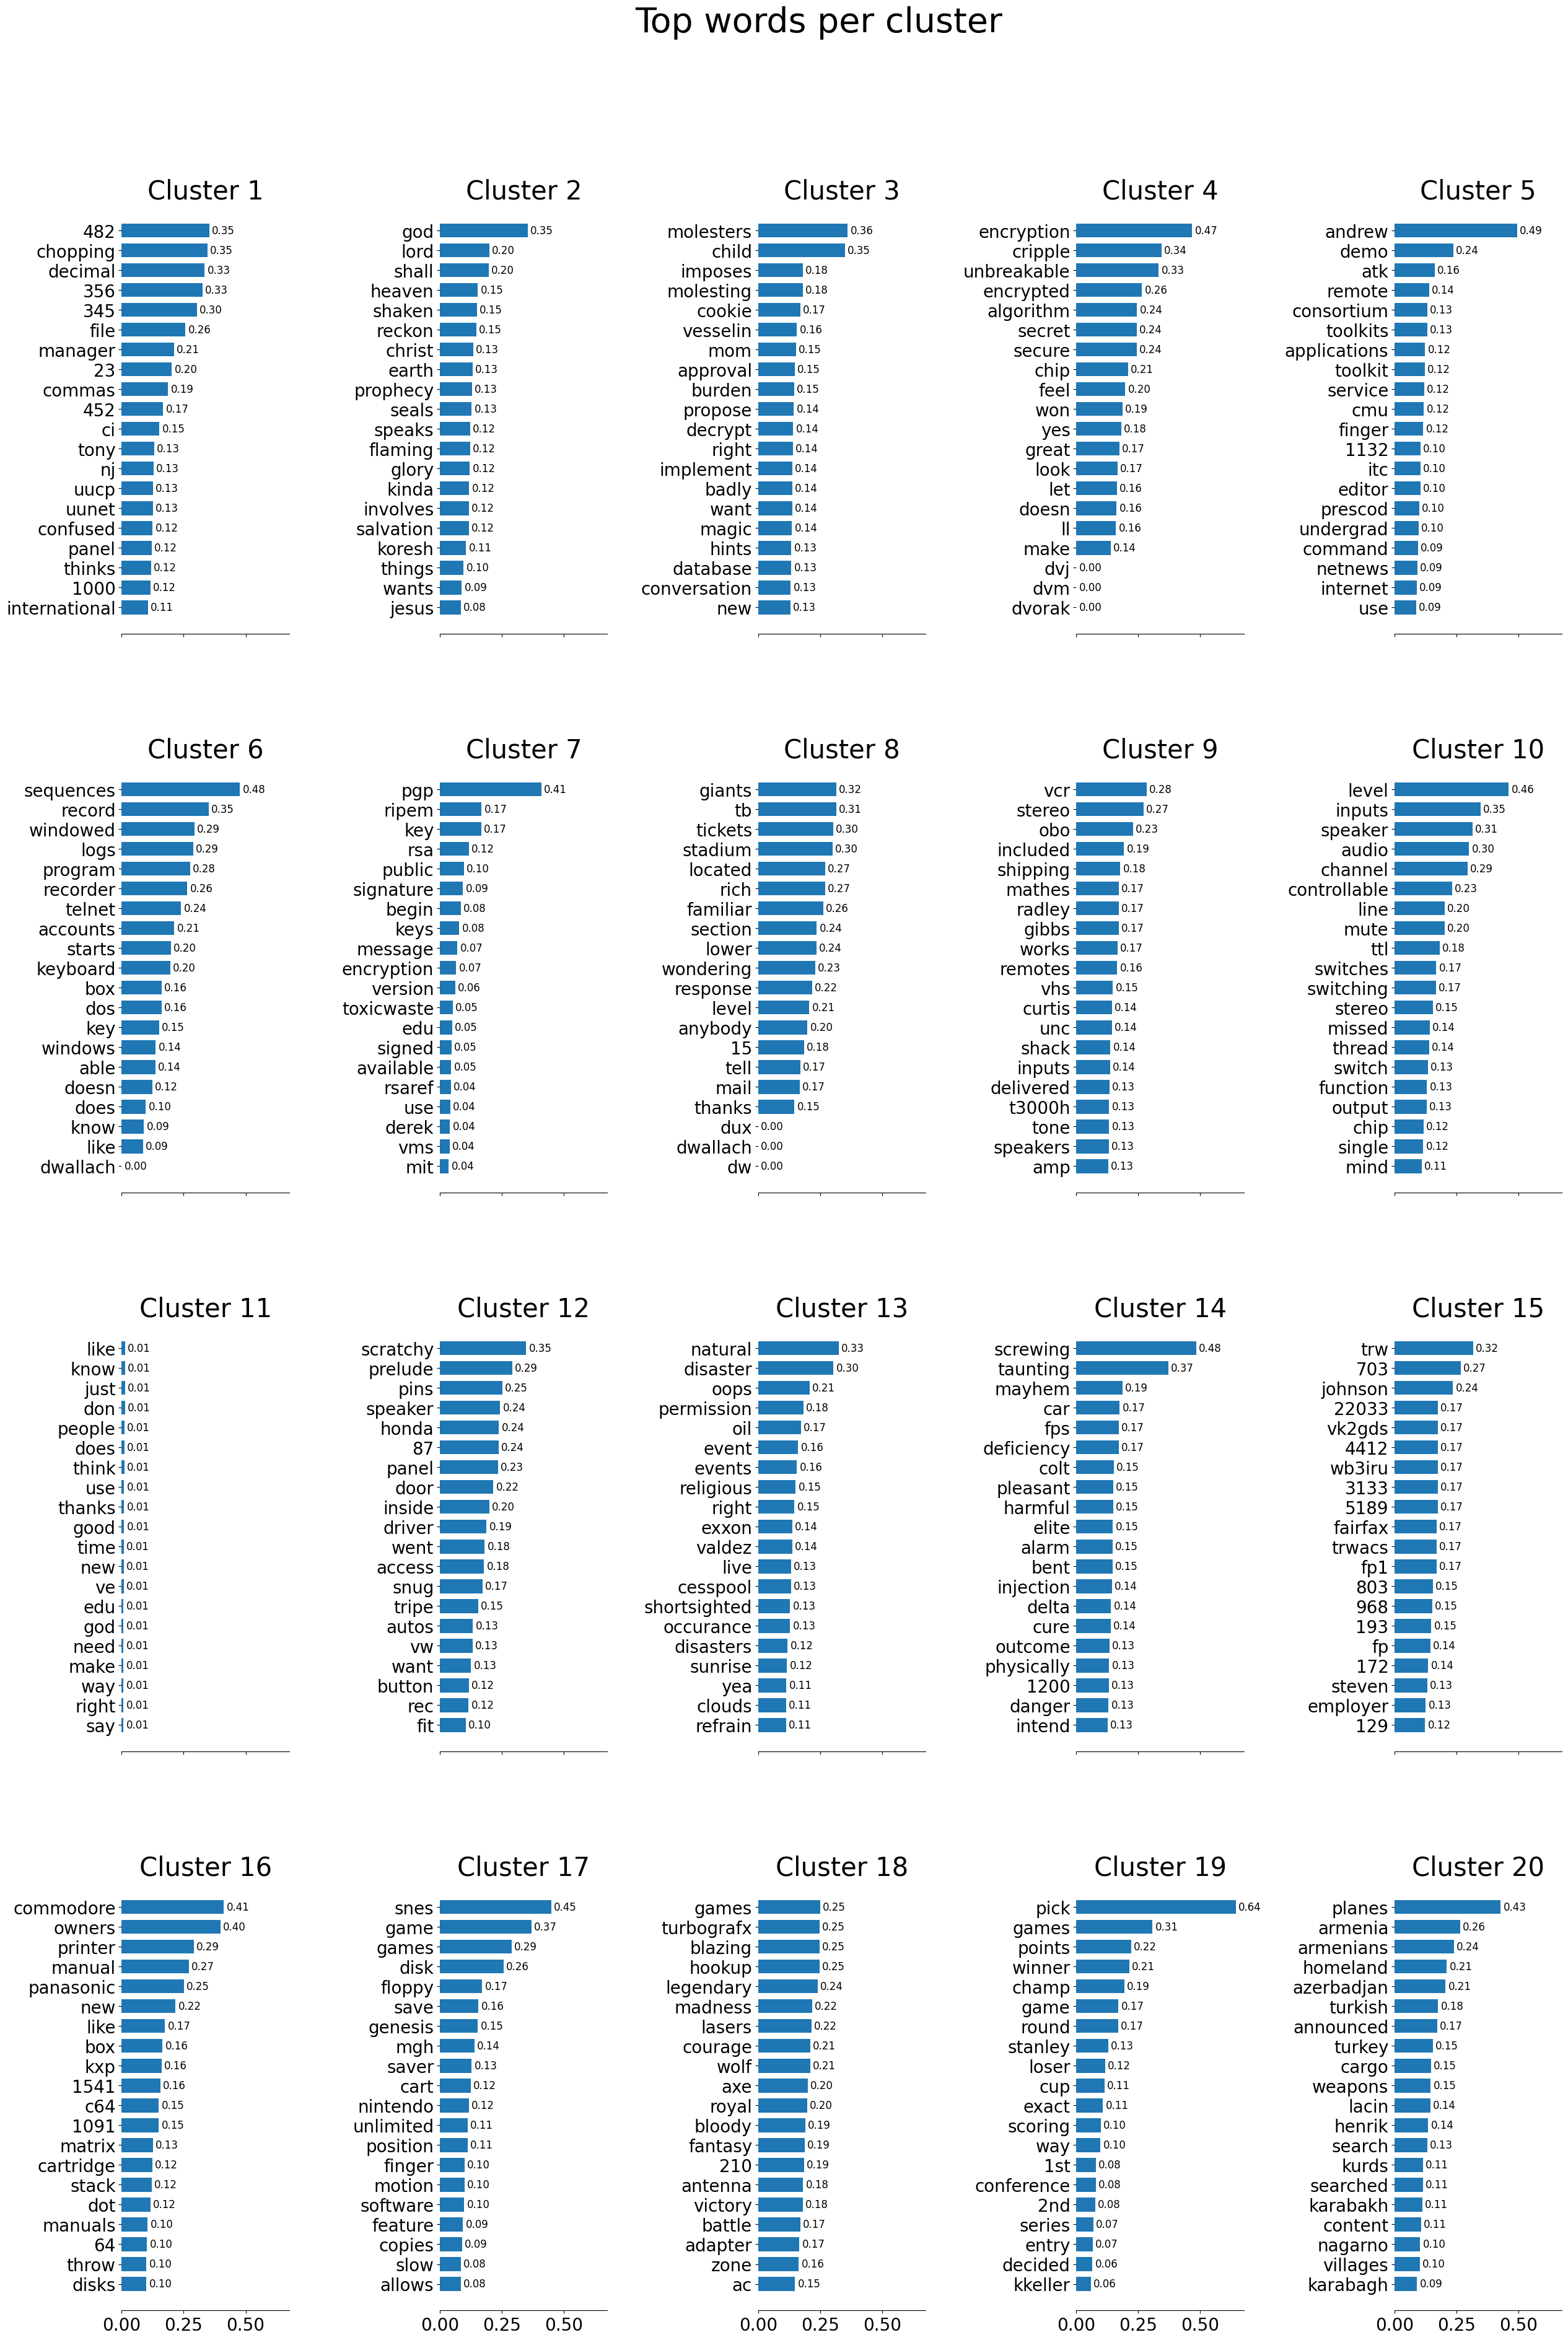

In [156]:
# display the top words in each cluster
plot_top_words(kmeans, feature_names, 20, "Top words per cluster")

In [184]:
# use TruncatedSVD to reduce the dimensionality of the data
svd = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
reduced_data = svd.fit_transform(X_test_tfidf)

In [159]:
# predict the labels
cluster_labels = kmeans.fit_predict(reduced_data)

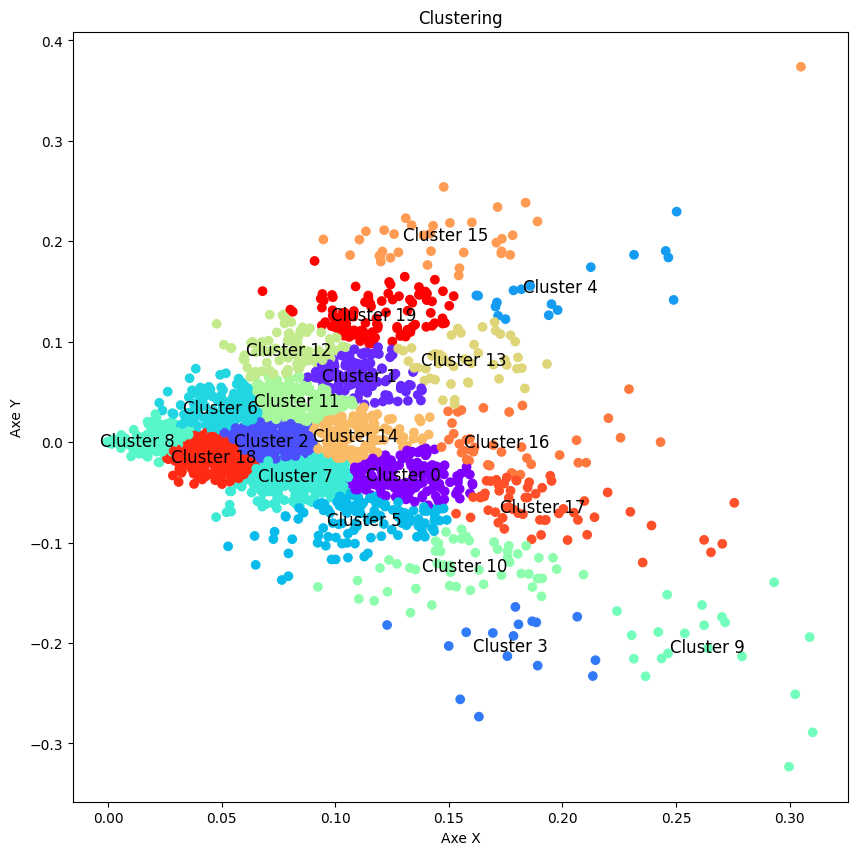

In [160]:
# visualise the clusters
cluster_names = {i: f"Cluster {i}" for i in range(cluster_labels.max() + 1)}
fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_labels, cmap='rainbow')
plt.xlabel('Axe X')
plt.ylabel('Axe Y')
plt.title('Clustering')
for cluster_id, cluster_name in cluster_names.items():
    cluster_points = reduced_data[cluster_labels == cluster_id]
    cluster_center = cluster_points.mean(axis=0)
    plt.text(cluster_center[0], cluster_center[1], cluster_name, fontsize=12, ha='center', va='center')

In [121]:
# display the results
bench_k_means(kmeans, X_test_tfidf, y_test_tfidf)

,adjusted_rand_score,adjusted_mutual_info_score,silhouette_score,homogeneity_score,completeness_score,v_measure_score
result,0.00005,0.00163,-0.012041,0.010047,0.350682,0.019534


### Clustering with LDA

In [180]:
# define LatentDirichletAllocation model
lda = LatentDirichletAllocation(
    n_components=20,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)

In [163]:
# fit the model
lda_tfidf = lda.fit(X_train_tfidf)
lda_tfidf

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, n_components=20, random_state=0)

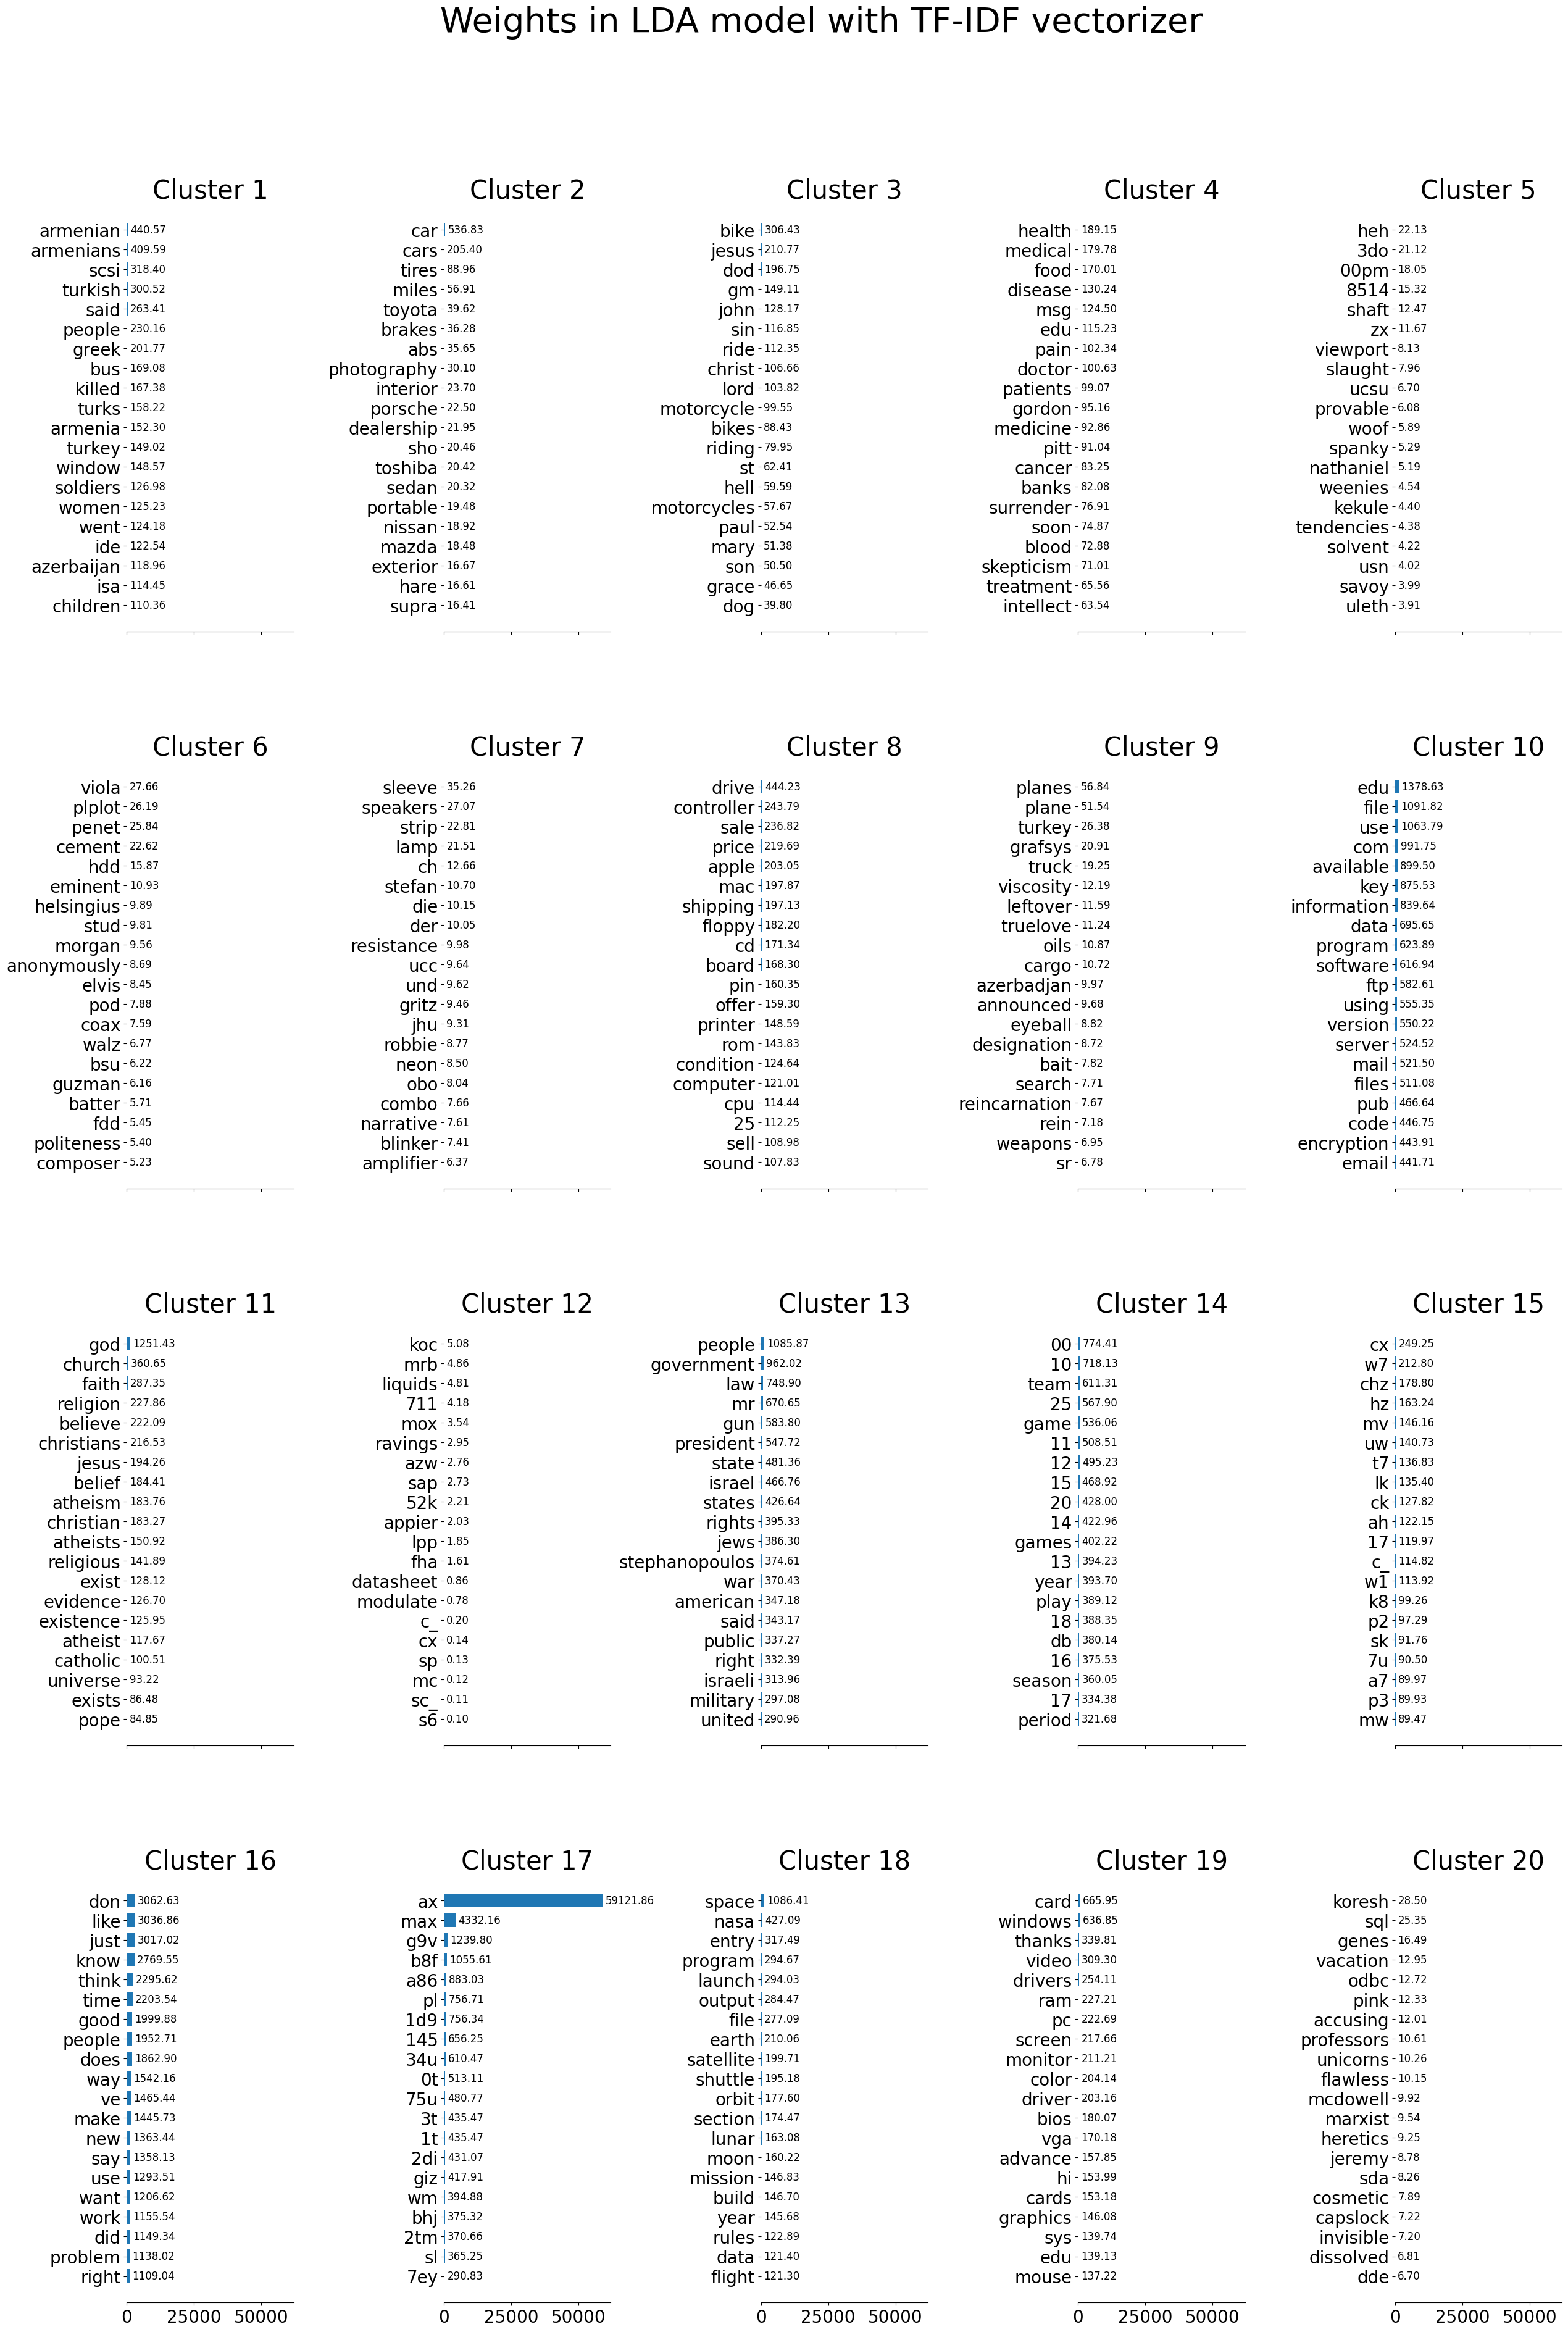

In [157]:
# display the top words in each cluster
plot_top_words(lda_tfidf, feature_names, 20, "Weights in LDA model with TF-IDF vectorizer")

In [191]:
# reduce the dimensionality of the data
cluster_labels = lda.fit_transform(reduced_data)

ValueError: Negative values in data passed to LatentDirichletAllocation.fit

In [176]:
# visualise the clusters
cluster_names = {i: f"Cluster {i}" for i in range(cluster_labels.max() + 1)}
fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_labels, cmap='rainbow')
plt.xlabel('Axe X')
plt.ylabel('Axe Y')
plt.title('Clustering')
for cluster_id, cluster_name in cluster_names.items():
    cluster_points = reduced_data[cluster_labels == cluster_id]
    cluster_center = cluster_points.mean(axis=0)
    plt.text(cluster_center[0], cluster_center[1], cluster_name, fontsize=12, ha='center', va='center')

TypeError: 'numpy.float64' object cannot be interpreted as an integer

In [400]:
# display the results
bench_estimator(lda_tfidf, X_test_tfidf, y_test_tfidf.reshape(-1, 1))

ValueError: X has 1 features, but LatentDirichletAllocation is expecting 1000 features as input.

In [388]:
# Create models
models = {
    "GradientBoostingClassifier": GradientBoostingClassifier(learning_rate=0.1, n_estimators=100),
    "LGBMClassifier": lgb.LGBMClassifier(boosting_type='gbdt', num_leaves=31, learning_rate=0.05, n_estimators=100),
    "XGBClassifier": xgb.XGBClassifier(learning_rate=0.1, n_estimators=100),
    "LogisticRegression": LogisticRegression(solver='liblinear'),
    "SVC": SVC(C=1.0, kernel='rbf'),
    "Perceptron": Perceptron(penalty='l2', alpha=0.0001)
}

In [165]:
# Transfrom the data into arrays
X_train_tfidf = X_train_tfidf.toarray()
X_test_tfidf = X_test_tfidf.toarray()

In [390]:
# Testons le modèle et mettons le en fonction
def test_model(X_train, X_test, y_train, y_test, models):
  metrics = {}
  for nom, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    class_metrics = {}
    # Ajout des noms et des scores
    class_metrics["accuracy"] = accuracy_score(y_test, y_pred)
    class_metrics["precision"] = precision_score(y_test, y_pred, average="macro")
    class_metrics["recall"] = recall_score(y_test, y_pred, average="macro")
    class_metrics["f1-score"] = f1_score(y_test, y_pred, average="macro")
    metrics[nom] = class_metrics
  metrics_df = pd.DataFrame.from_dict(metrics, orient='index')
  return metrics_df.style.highlight_max(color="red")

In [391]:
# Evaluate the models
test_model_tfidf = test_model(X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf, models)
test_model_tfidf

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013562 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 73674
[LightGBM] [Info] Number of data points in the train set: 9051, number of used features: 971
[LightGBM] [Info] Start training from score -3.147051
[LightGBM] [Info] Start training from score -2.994738
[LightGBM] [Info] Start training from score -2.981580
[LightGBM] [Info] Start training from score -2.972903
[LightGBM] [Info] Start training from score -2.983761
[LightGBM] [Info] Start training from score -2.949423
[LightGBM] [Info] Start training from score -2.934763
[LightGBM] [Info] Start training from score -2.947316
[LightGBM] [Info] Start training from score -2.953652
[LightGBM] [Info] Start training from score -2.924422
[LightGBM] [Info] Start training from score -2.922366
[LightGBM] [Info] Start training from score -2.94521

,accuracy,precision,recall,f1-score
GradientBoostingClassifier,0.519664,0.533189,0.513205,0.517496
LGBMClassifier,0.554574,0.554452,0.548721,0.547978
XGBClassifier,0.530711,0.540527,0.525700,0.528011
LogisticRegression,0.574017,0.575066,0.568032,0.561712
SVC,0.572691,0.593107,0.566769,0.565158
Perceptron,0.456916,0.555879,0.445218,0.435791
